## Generating Benchmark Data for Wikipedia Dataset

The data is taken from the [Web Traffic Time Series Forecasting
](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/overview) challenge on Kaggle, a research competiton organized by Google ($25,000).

In [1]:
STORE_ROOT = "wikipedia"
NIXTLA_ROOT = "wikipedia_nixtla"
ROOT = "/data/cmu/large-scale-hts-reconciliation/"
data_dir = ROOT + "notebooks/"
TIME_HORIZON = 100

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm
import pickle

Importing plotly failed. Interactive plots will not work.


### ETL (Extract, Transform & Load) from Kaggle

In [13]:
df = pd.read_csv(data_dir + 'train_1.csv').fillna(0)
df['level_4'] = df['Page']
df['level_3'] = df['Page'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df['level_2'] = df['Page'].apply(lambda x: '_'.join(x.split('_')[:-2]))
df['level_1'] = df['Page'].apply(lambda x: x.split('_')[-3])

import collections
collections.Counter(df['level_1'].values)

Counter({'zh.wikipedia.org': 17229,
         'fr.wikipedia.org': 17802,
         'en.wikipedia.org': 24108,
         'commons.wikimedia.org': 10555,
         'ru.wikipedia.org': 15022,
         'www.mediawiki.org': 7300,
         'de.wikipedia.org': 18547,
         'ja.wikipedia.org': 20431,
         'es.wikipedia.org': 14069})

In [14]:
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,level_4,level_3,level_2,level_1
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1_zh.wikipedia.org_all-access_spider,2NE1_zh.wikipedia.org_all-access,2NE1_zh.wikipedia.org,zh.wikipedia.org
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access,2PM_zh.wikipedia.org,zh.wikipedia.org
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access,3C_zh.wikipedia.org,zh.wikipedia.org
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access,4minute_zh.wikipedia.org,zh.wikipedia.org
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You_zh.wikipedia.org_all-access,52_Hz_I_Love_You_zh.wikipedia.org,zh.wikipedia.org
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,12.0,13.0,3.0,5.0,10.0,Underworld_(serie_de_películas)_es.wikipedia.o...,Underworld_(serie_de_películas)_es.wikipedia.o...,Underworld_(serie_de_películas)_es.wikipedia.org,es.wikipedia.org
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Resident_Evil:_Capítulo_Final_es.wikipedia.org,es.wikipedia.org
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Enamorándome_de_Ramón_es.wikipedia.org_all-access,Enamorándome_de_Ramón_es.wikipedia.org,es.wikipedia.org
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Hasta_el_último_hombre_es.wikipedia.org,es.wikipedia.org


### Compiling the hierarchies

In [15]:
try:
    df.drop(columns = ['Page'], inplace=True)
except:
    _  = 1
    
df['unique_id'] = df['level_4']

In [16]:
df

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,level_4,level_3,level_2,level_1,unique_id
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,20.0,22.0,19.0,18.0,20.0,2NE1_zh.wikipedia.org_all-access_spider,2NE1_zh.wikipedia.org_all-access,2NE1_zh.wikipedia.org,zh.wikipedia.org,2NE1_zh.wikipedia.org_all-access_spider
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,30.0,52.0,45.0,26.0,20.0,2PM_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access,2PM_zh.wikipedia.org,zh.wikipedia.org,2PM_zh.wikipedia.org_all-access_spider
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,6.0,3.0,4.0,17.0,3C_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access,3C_zh.wikipedia.org,zh.wikipedia.org,3C_zh.wikipedia.org_all-access_spider
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,11.0,17.0,19.0,10.0,11.0,4minute_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access,4minute_zh.wikipedia.org,zh.wikipedia.org,4minute_zh.wikipedia.org_all-access_spider
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You_zh.wikipedia.org_all-access,52_Hz_I_Love_You_zh.wikipedia.org,zh.wikipedia.org,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,13.0,3.0,5.0,10.0,Underworld_(serie_de_películas)_es.wikipedia.o...,Underworld_(serie_de_películas)_es.wikipedia.o...,Underworld_(serie_de_películas)_es.wikipedia.org,es.wikipedia.org,Underworld_(serie_de_películas)_es.wikipedia.o...
145059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,Resident_Evil:_Capítulo_Final_es.wikipedia.org,es.wikipedia.org,Resident_Evil:_Capítulo_Final_es.wikipedia.org...
145060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,Enamorándome_de_Ramón_es.wikipedia.org_all-access,Enamorándome_de_Ramón_es.wikipedia.org,es.wikipedia.org,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...
145061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,Hasta_el_último_hombre_es.wikipedia.org,es.wikipedia.org,Hasta_el_último_hombre_es.wikipedia.org_all-ac...


In [49]:
level_3_map = dict(zip(df.level_3.values, zip(df.level_2.values, df.level_1.values)))
level_2_map = dict(zip(df.level_2.values, df.level_1.values))

In [50]:
level_2_map

{'2NE1_zh.wikipedia.org': 'zh.wikipedia.org',
 '2PM_zh.wikipedia.org': 'zh.wikipedia.org',
 '3C_zh.wikipedia.org': 'zh.wikipedia.org',
 '4minute_zh.wikipedia.org': 'zh.wikipedia.org',
 '52_Hz_I_Love_You_zh.wikipedia.org': 'zh.wikipedia.org',
 '5566_zh.wikipedia.org': 'zh.wikipedia.org',
 '91Days_zh.wikipedia.org': 'zh.wikipedia.org',
 "A'N'D_zh.wikipedia.org": 'zh.wikipedia.org',
 'AKB48_zh.wikipedia.org': 'zh.wikipedia.org',
 'ASCII_zh.wikipedia.org': 'zh.wikipedia.org',
 'ASTRO_zh.wikipedia.org': 'zh.wikipedia.org',
 'Ahq_e-Sports_Club_zh.wikipedia.org': 'zh.wikipedia.org',
 'All_your_base_are_belong_to_us_zh.wikipedia.org': 'zh.wikipedia.org',
 'AlphaGo_zh.wikipedia.org': 'zh.wikipedia.org',
 'Android_zh.wikipedia.org': 'zh.wikipedia.org',
 'Angelababy_zh.wikipedia.org': 'zh.wikipedia.org',
 'Apink_zh.wikipedia.org': 'zh.wikipedia.org',
 'Apple_II_zh.wikipedia.org': 'zh.wikipedia.org',
 'As_One_zh.wikipedia.org': 'zh.wikipedia.org',
 'B-PROJECT_zh.wikipedia.org': 'zh.wikipedia.org',

#### Roll-up to produce parent forecasts

In [17]:
tags = {}
tags['level_4'] = df['level_4'].unique()
tags['level_3'] = df['level_3'].unique()
tags['level_2'] = df['level_2'].unique()
tags['level_1'] = df['level_1'].unique()
tags

{'level_4': array(['2NE1_zh.wikipedia.org_all-access_spider',
        '2PM_zh.wikipedia.org_all-access_spider',
        '3C_zh.wikipedia.org_all-access_spider', ...,
        'Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider',
        'Hasta_el_último_hombre_es.wikipedia.org_all-access_spider',
        'Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider'],
       dtype=object),
 'level_3': array(['2NE1_zh.wikipedia.org_all-access',
        '2PM_zh.wikipedia.org_all-access',
        '3C_zh.wikipedia.org_all-access', ...,
        '学校法人森友学園_ja.wikipedia.org_all-access',
        'Discussion:Scintillation_fr.wikipedia.org_all-access',
        'xss_ja.wikipedia.org_all-access'], dtype=object),
 'level_2': array(['2NE1_zh.wikipedia.org', '2PM_zh.wikipedia.org',
        '3C_zh.wikipedia.org', ...,
        'Eine_Reihe_betrüblicher_Ereignisse_(Fernsehserie)_de.wikipedia.org',
        'ジャック・リーチャー_ja.wikipedia.org', 'マイク眞木_ja.wikipedia.org'],
       dty

In [22]:
node_map = {}
node_map_inv = {}

i = 0

for l in ['level_4', 'level_3', 'level_2', 'level_1']:
    for c in tags[l]:
        node_map[i] = c
        node_map_inv[c] = i
        i += 1

total_bottom = len(tags['level_4'])
total_parent = len(tags['level_3']) + len(tags['level_2']) + len(tags['level_1'])
parents = list(tags['level_3']) + list(tags['level_2']) + list(tags['level_1'])
time_index = (df.columns)[:-5]

In [23]:
pickle.dump([node_map_inv, node_map], open(data_dir + 'wikipedia_node_map.pkl', 'wb'))

In [24]:
parent_historical = np.zeros((total_parent, len(time_index))).astype(np.int64)

for _, ro in tqdm(df.iterrows()):
    vals = ro[time_index].values.astype(np.int64)
    parent_historical[node_map_inv[ro['level_3']] - total_bottom, :] += vals
    parent_historical[node_map_inv[ro['level_2']] - total_bottom, :] += vals
    parent_historical[node_map_inv[ro['level_1']] - total_bottom, :] += vals

145063it [01:00, 2404.59it/s]


In [51]:
parent_df = pd.DataFrame(data = parent_historical)
parent_df.columns = time_index

parent_df['unique_id'] = parents
parent_df['level_4'] = np.nan

#df['level_4'] = df['Page']
#df['level_3'] = df['Page'].apply(lambda x: '_'.join(x.split('_')[:-1]))
#df['level_2'] = df['Page'].apply(lambda x: '_'.join(x.split('_')[:-2]))
#df['level_1'] = df['Page'].apply(lambda x: x.split('_')[-3])

def p0(x):
    if x in level_3_map: return x
    return np.nan
    #l = x.split('_')
    #if len(l) < 3: return np.nan
    #return x

def p1(x):
    if x in level_3_map: return level_3_map[x][0]
    if x in level_2_map: return x
    return np.nan
    #l = x.split('_')
    #if len(l) < 2: return np.nan
    #return '_'.join(l[:-1])

def p2(x):
    if x in level_3_map: return level_3_map[x][1]
    if x in level_2_map: return level_2_map[x]
    return x
    #l = x.split('_')
    #if len(l) < 3: return np.nan
    #return l[-(min(len(l), 3) - 1)]

parent_df['level_3'] = parent_df['unique_id'].apply(p0)
parent_df['level_2'] = parent_df['unique_id'].apply(p1)
parent_df['level_1'] = parent_df['unique_id'].apply(p2)
parent_df

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,unique_id,level_4,level_3,level_2,level_1
0,803,736,646,717,704,666,679,720,817,771,...,672,676,570,661,592,2NE1_zh.wikipedia.org_all-access,NaN,2NE1_zh.wikipedia.org_all-access,2NE1_zh.wikipedia.org,zh.wikipedia.org
1,1582,1861,1694,1606,1740,1669,1608,1553,1528,1639,...,932,905,769,721,648,2PM_zh.wikipedia.org_all-access,NaN,2PM_zh.wikipedia.org_all-access,2PM_zh.wikipedia.org,zh.wikipedia.org
2,12,9,20,10,5,31,9,17,22,16,...,18,21,14,10,41,3C_zh.wikipedia.org_all-access,NaN,3C_zh.wikipedia.org_all-access,3C_zh.wikipedia.org,zh.wikipedia.org
3,781,750,679,1048,762,860,779,782,905,911,...,384,367,338,354,370,4minute_zh.wikipedia.org_all-access,NaN,4minute_zh.wikipedia.org_all-access,4minute_zh.wikipedia.org,zh.wikipedia.org
4,0,0,0,0,0,0,0,0,0,0,...,721,1020,697,653,626,52_Hz_I_Love_You_zh.wikipedia.org_all-access,NaN,52_Hz_I_Love_You_zh.wikipedia.org_all-access,52_Hz_I_Love_You_zh.wikipedia.org,zh.wikipedia.org
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162936,9463854,9627643,8923463,8393214,8938528,9628896,9408180,9364117,9592309,10984872,...,15040168,14000319,13478977,12066750,13223033,ru.wikipedia.org,NaN,NaN,NaN,ru.wikipedia.org
162937,349713,383680,325714,308756,338485,391895,433312,372333,331655,399316,...,320017,729836,320695,431709,392930,www.mediawiki.org,NaN,NaN,NaN,www.mediawiki.org
162938,13260519,13079896,12554042,11520379,13392347,14741758,14296292,14505194,13964778,13014478,...,20125264,19152389,18447906,17606030,16562720,de.wikipedia.org,NaN,NaN,NaN,de.wikipedia.org
162939,11863200,13620792,12305383,15456239,14827204,12920547,12568828,12492787,12178258,12652904,...,16123301,16150715,17682688,19450687,24460799,ja.wikipedia.org,NaN,NaN,NaN,ja.wikipedia.org


In [52]:
total_df = pd.concat([df, parent_df])
total_df.to_csv(data_dir + 'wikipedia_historical.csv', index=False)

#### Compute edge list for LHTS

In [53]:
edge_list = []
parent_list = []

for i, ro in tqdm(total_df.iterrows()):
    if type(ro['level_4']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['level_3']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['level_3']],
                            node_map_inv[ro['level_2']],
                            node_map_inv[ro['level_1']],
                            ])
    elif type(ro['level_3']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['level_2']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['level_2']],
                            node_map_inv[ro['level_1']],
                            -1
                            ])
    elif type(ro['level_2']) is str:
        edge_list.append([node_map_inv[ro['unique_id']], node_map_inv[ro['level_1']]])
        parent_list.append([node_map_inv[ro['unique_id']], 
                            node_map_inv[ro['level_1']],
                            -1,
                            -1
                            ])
    else:
        parent_list.append([node_map_inv[ro['unique_id']], 
                            -1, -1, -1])

308004it [00:32, 9399.42it/s] 


In [55]:
np.save(open(data_dir + STORE_ROOT + '/wikipedia_hierarchy.npy', 'wb'), np.array(edge_list))
np.save(open(data_dir + STORE_ROOT + '/hierarchy.npy', 'wb'), np.array(edge_list))
np.save(open(data_dir + STORE_ROOT + '/wikipedia_hierarchy_parent.npy', 'wb'), np.array(parent_list))

In [56]:
np.array(parent_list).shape

(308004, 4)

Forecasting is done on a separate file. Here's what it roughly looks like.

```python
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=120) # over-subscribing

forecast_horizon = 100

def predict(row):
    data = pd.DataFrame({'ds': (row.index)[1:][-forecast_horizon:], 'y':(row.values)[1:][-forecast_horizon:]})
    m = Prophet()
    m.fit(data)
    
    future = m.make_future_dataframe(periods=forecast_horizon)
    future.tail()
    forecast = m.predict(future)

    return row.Page, forecast[['yhat']][-forecast_horizon:].values.reshape(-1)
```

### Sanity check by plotting

In [57]:
import pickle
predictions = pickle.load(open(data_dir + 'wikipedia_time_series_prediction_raw/wikipedia_prophet_forecast_result.pkl', 'rb'))

In [58]:
predictions

0         (2NE1_zh.wikipedia.org_all-access_spider, [33....
1         (2PM_zh.wikipedia.org_all-access_spider, [19.1...
2         (3C_zh.wikipedia.org_all-access_spider, [10.29...
3         (4minute_zh.wikipedia.org_all-access_spider, [...
4         (52_Hz_I_Love_You_zh.wikipedia.org_all-access_...
                                ...                        
145058    (Underworld_(serie_de_películas)_es.wikipedia....
145059    (Resident_Evil:_Capítulo_Final_es.wikipedia.or...
145060    (Enamorándome_de_Ramón_es.wikipedia.org_all-ac...
145061    (Hasta_el_último_hombre_es.wikipedia.org_all-a...
145062    (Francisco_el_matemático_(serie_de_televisión_...
Name: float, Length: 145063, dtype: object

smape:  69.803


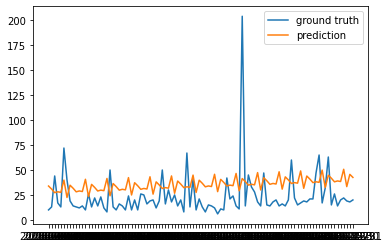

In [77]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions[0][1]
index = list(df.columns)[0:-5][-100:]
gt = df.iloc[0,:-5].values[-100:]

sns.lineplot(x=index, y=gt, label='ground truth')
sns.lineplot(x=index, y=pred, label='prediction')

print("smape: ", smape(gt, pred).round(3))

### Export LHTS format

In [78]:
pickle.dump(time_index, open(data_dir + "wikipedia_time_index_all.pkl", "wb"))

In [80]:
total_ts = total_bottom + total_parent

pred_tensor = np.zeros((total_ts, TIME_HORIZON))
gt_tensor = np.zeros((total_ts, TIME_HORIZON))

for i, ro in tqdm(total_df.iterrows()):
    gt_tensor[node_map_inv[ro.unique_id], :] = ro.values[:-5][-TIME_HORIZON:]
    
for unique_id, pred in tqdm(predictions):
    pred_tensor[node_map_inv[unique_id], :] = pred

308004it [00:28, 10978.58it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145063/145063 [00:00<00:00, 504303.23it/s]


In [81]:
top_down_tensor = np.zeros((total_ts, TIME_HORIZON))
for l in tqdm(parent_list):
    i = l[0]
    for c in [l[3], l[2], l[1]]:
        if c != -1: break
    top_down_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308004/308004 [00:01<00:00, 240402.67it/s]


In [82]:
level_2_tensor = np.zeros((total_ts, TIME_HORIZON))

for l in tqdm(parent_list):
    nz = list(filter(lambda x: x!=-1, l))
    if len(nz) == 1: continue
    i = l[0]
    c = l[-2]
    level_2_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)
    
level_3_tensor = np.zeros((total_ts, TIME_HORIZON))

for l in tqdm(parent_list):
    nz = list(filter(lambda x: x!=-1, l))
    if len(nz) <= 2: continue
    i = l[0]
    c = l[-3]
    level_3_tensor[i, :] = gt_tensor[i, :] / (gt_tensor[c, :] + 1e-9)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308004/308004 [00:01<00:00, 235942.47it/s]


In [83]:
np.save(open(data_dir + STORE_ROOT + '/pred_tensor.npy', 'wb'), pred_tensor)
np.save(open(data_dir + STORE_ROOT + '/gt_tensor.npy', 'wb'), gt_tensor)
np.save(open(data_dir + STORE_ROOT + '/top_down_tensor.npy', 'wb'), top_down_tensor)
np.save(open(data_dir + STORE_ROOT + '/level_2_tensor.npy', 'wb'), level_2_tensor)
np.save(open(data_dir + STORE_ROOT + '/level_3_tensor.npy', 'wb'), level_3_tensor)

pred_tensor.shape

(308004, 100)

In [84]:
N_CHUNKS = 8

for t, n in [(pred_tensor, 'pred_tensor'),
          (gt_tensor, 'gt_tensor'),
          (top_down_tensor, 'top_down_tensor'),
          (level_2_tensor, 'level_2_tensor'),
          (level_3_tensor, 'level_3_tensor')
         ]:
    l = np.array_split(t, N_CHUNKS)
    for i, p in enumerate(l):
        np.save(open(data_dir + STORE_ROOT + '/mpi/'+ n + '_' + str(i) + '.npy', 'wb'), p)

### Export Nixtla format

In [85]:
pickle.dump(tags, open(NIXTLA_ROOT + '/tags.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'wikipedia_nixtla/tags.pkl'

In [30]:
y_gt = {'unique_id': [], 'ds': [], 'y': []}
yhat = {'unique_id': [], 'ds': [], 'y': []}

idx = time_index[-TIME_HORIZON:]

for _, ro in tqdm(total_df.iterrows()):
    vals = ro[time_index].values.astype(np.int64)[-TIME_HORIZON:]
    for i in range(TIME_HORIZON):
        y_gt['unique_id'].append(ro.unique_id)
        y_gt['ds'].append(idx[i])
        y_gt['y'].append(vals[i])
        
for unique_id, pred in tqdm(predictions):
    for i in range(TIME_HORIZON):
        yhat['unique_id'].append(unique_id)
        yhat['ds'].append(idx[i])
        yhat['y'].append(pred[i])

29895it [00:44, 671.57it/s]


KeyboardInterrupt: 

In [ ]:
Y_gt = pd.DataFrame(y_gt)
Y_hat = pd.DataFrame(yhat)
Y_hat.rename(columns = {'y': 'prophet'}, inplace=True)

Y_gt.to_csv(data_dir + NIXTLA_ROOT + '/nixtla_y_gt.csv', index=False)
Y_hat.to_csv(data_dir + NIXTLA_ROOT + '/nixtla_y_hat.csv', index=False)

In [ ]:
import gc
nrow = len(tags['level_1']) + len(tags['level_2']) + len(tags['level_3']) + len(tags['level_4'])
ncol = len(tags['level_4'])

columns = list(tags['level_4'])
rows = list(tags['level_1']) + list(tags['level_2']) + list(tags['level_3']) + list(tags['level_4'])

## The following is not possible because it OOMs.

In [ ]:
#raw_S = np.zeros((nrow, ncol))

In [ ]:
rows_map = {v:k for k,v in dict(enumerate(rows)).items()}
columns_map = {v:k for k,v in dict(enumerate(columns)).items()}

In [ ]:
for i, ro in tqdm(total_df.iterrows(), total=len(total_df)):
    if ro.unique_id not in columns_map: continue
    co = columns_map[ro.unique_id]
    ro4 = ro['Cat/Dept/Item/State']
    ro3 = ro['Cat/Dept/Item']
    ro2 = ro['Cat/Dept']
    ro1 = ro['Cat']
    if type(ro4) is str:
        raw_S[rows_map[ro4], co] = 1
    if type(ro3) is str:
        raw_S[rows_map[ro3], co] = 1
    if type(ro2) is str:
        raw_S[rows_map[ro2], co] = 1
    if type(ro1) is str:
        raw_S[rows_map[ro1], co] = 1

In [ ]:
raw_S.shape, pred_tensor.shape

In [ ]:
np.save(open(data_dir + NIXTLA_ROOT + '/S_tensor.npy', 'wb'), raw_S)

In [ ]:
S_df = pd.DataFrame(data=raw_S, dtype=np.int8)
S_df.columns = columns
S_df.index = rows

In [ ]:
pickle.dump(S_df, open(NIXTLA_ROOT + '/nixtla_s.pkl', 'wb'))